# PCST reductions on Road Maps
#This example retrieves a graph from [OpenStreetMap](https://www.openstreetmap.org) via the [osmnx](https://osmnx.readthedocs.io) package.
#Blablabla

## Imports

In [1]:
import random
import networkx as nx

import osmnx as ox
import pyproj
import time

from graphilp.imports import networkx as imp_nx
from graphilp.network import pcst_linear as pl
from graphilp.network.reductions import pcst_utilities as pu
from graphilp.network.reductions import pcst_basic_reductions as br
from graphilp.network.reductions import pcst_voronoi as vor
from graphilp.network.reductions import pcst_dualAscent as da

## Choose reduction techniques

In [2]:
# Choose which reduction techniques to use
basic_reductions_active = True
voronoi_active = False
dualAscent_active = True

# Variables for time evaluation
basic_reductions_time = 0
voronoi_time = 0
dualAscent_time = 0
gurobi_with_reductions_time = 0
gurobi_without_reductions_time = 0

# Variables for adding more constraints based on reductions
term_deg2 = None
nodes_deg3 = None
fixed_terminals = None

## Set up the graph

In [3]:
crs = pyproj.crs.CRS('epsg:31467')

In [4]:
place = 'Carlstadt, Düsseldorf, Deutschland'

# road network of suburb (converted to Gauss-Krüger 3)
G_ox = ox.project_graph(ox.graph_from_place(place, network_type='walk'), to_crs=crs)


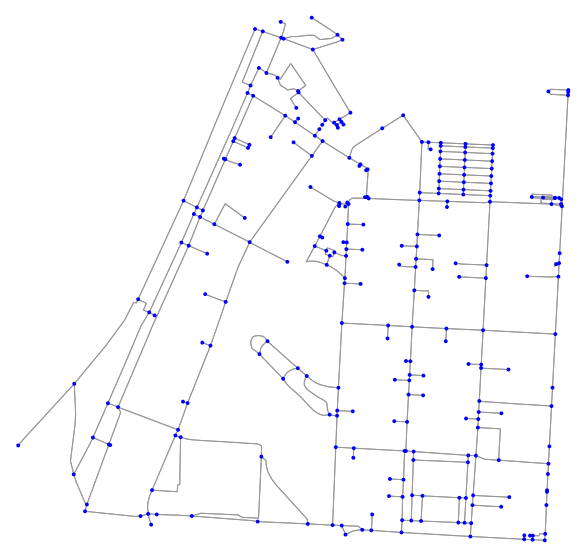

In [5]:
#draw the road map
ox.plot_graph(G_ox, figsize=(14, 10),
              bgcolor='#FFF',
              node_color='b');

In [6]:
node_list = list(G_ox.nodes())

In [7]:
# choose random terminals
num_terminals = 5
#terminals = [node_list[random.randint(0, len(node_list))] for n in range(num_terminals)]
terminals = [595793277, 1561453934, 4278832131, 3314944018, 8096912480]

print(terminals)

[595793277, 1561453934, 4278832131, 3314944018, 8096912480]


In [8]:
# Set up the profit of the nodes (What is the profit of terminals?)
for node in G_ox.nodes():
    if node in terminals:
        G_ox.nodes[node]['prize'] = 300
    else:
        G_ox.nodes[node]['prize'] = 0

In [9]:
#Set up a root
root = terminals[0]
print("Root: ", root)

Root:  595793277


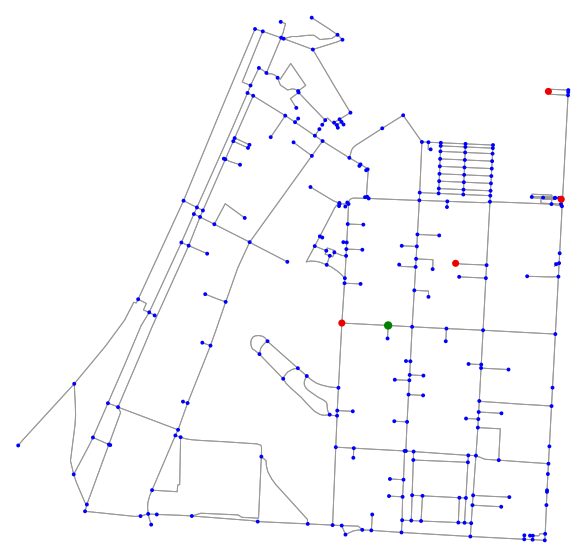

In [10]:
# draw road map and terminals
ox.plot_graph(G_ox, figsize=(14, 10),
    bgcolor='#FFF',
    node_color=['g' if n == root else'#ED0000' if n in terminals else '#00F' for n in node_list],
    node_size=[70 if n == root else 50 if n in terminals else 15 for n in node_list]);

In [11]:
# Print size of graph
pu.show_graph_size(G_ox, "Original graph: ")

Original graph: 
Number of nodes: 277
Number of edges: 692
Number of terminals: 5
#########################


In [12]:
# Transformation of the MultiDiGraph to a DiGraph because Networkx doesn't fully support Multigraphs.
G = nx.DiGraph()
dropped = 0
for u,v,data in G_ox.edges(data=True):
    if G.has_edge(u,v):
        continue
    else:
        G.add_edge(u, v)
        G.nodes[u]['prize'] = G_ox.nodes[u]['prize']
        G.nodes[v]['prize'] = G_ox.nodes[v]['prize']
        for k in data.keys():
            G.edges[(u,v)][k] = data.get(k)
for e in G.edges():
    G.edges[e]['weight'] = G.get_edge_data(e[0], e[1])['length']




## Solve the instance without any reductions for comparison

In [13]:
# Solve the instance without any reductions for comparison
time_start = time.time()
solution, best_val = pu.gurobi(G, root)
#solution, best_val = 0, 0
#solution = [(595793277, 1561453934), (1561453933, 595793277), (596188953, 1561453933), (584047447, 1561453932), (584047465, 584047447), (584047465, 4278832131), (1561453932, 596188953), (1561453964, 584047465), (5093054218, 1561453964), (5093054218, 4028758284), (1561453966, 5093054218), (3314944014, 1561453966), (3314944014, 3314944018), (4028758284, 8096912481), (8096912481, 8096912480)]

time_end = time.time()
gurobi_without_reductions_time = time_end - time_start

print("\nGurobi took " + str(gurobi_without_reductions_time) + " Seconds to compute.")
print("Edges in solution (for debugging): ", solution, "\n")

Academic license - for non-commercial use only - expires 2021-06-05
Using license file /home/addimator/gurobi.lic
Changed value of parameter threads to 3
   Prev: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 6 physical cores, 6 logical processors, using up to 3 threads
Optimize a model with 1920 rows, 1236 columns and 8057 nonzeros
Model fingerprint: 0xe5b837ac
Variable types: 0 continuous, 1236 integer (959 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+00, 3e+02]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 539.1670000
Presolve removed 216 rows and 72 columns
Presolve time: 0.01s
Presolved: 1704 rows, 1164 columns, 6860 nonzeros
Variable types: 0 continuous, 1164 integer (887 binary)

Root relaxation: objective 1.051635e+03, 1139 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work

## Use Reductions

### Basic Reductions

In [14]:
if basic_reductions_active:
    time_start = time.time()
    br.basic_reductions(G, root)
    # Print size of graph
    pu.show_graph_size(G, "Basic reductions: ")
    time_end = time.time()
    basic_reductions_time = time_end - time_start
    print("Basic reductions took " + str(basic_reductions_time) + " Seconds to compute.\n")

Basic reductions: 
Number of nodes: 207
Number of edges: 542
Number of terminals: 5
#########################
Basic reductions took 0.0009529590606689453 Seconds to compute.



for e in solution:
    if e not in G.edges:
        print("aesröjgtpasiohjgt" , e)
    else:
        print("OK")

### Voronoi

In [15]:
if voronoi_active:
    time_start = time.time()
    try:
        term_deg2, nodes_deg3 = vor.reductionTechniques(G, root)
    except KeyError:
        # If PCST fast throws a Key Error the upper bound solution is only the root note and therefore the real solution is only the root node.
        print("Pcst-fast found only Root note, no Graph for the upperBound could be built. Solution is trivial.")
        nodes_to_remove = [n for n in G.nodes if n != root and n not in list(G.neighbors(root))]
        G.remove_nodes_from(nodes_to_remove)
    pu.show_graph_size(G, "Voronoi: ")
    time_end = time.time()
    voronoi_time = time_end - time_start
    print("Voronoi took " + str(voronoi_time) + " Seconds to compute.\n")

### Dual Ascent

In [16]:

if dualAscent_active:
    time_start = time.time()
    try:
        G, fixed_terminals = da.dual_ascent_tests(G, root)
    except KeyError:
        # If PCST fast throws a Key Error the upper bound solution is only the root note and therefore the real solution is only the root node.
        print("Pcst-fast found only Root note, no Graph for the upperBound could be built. Solution is trivial.")
        nodes_to_remove = [n for n in G.nodes if n != root and n not in list(G.neighbors(root))]
        G.remove_nodes_from(nodes_to_remove)
    pu.show_graph_size(G, "Dual Ascent: ")
    time_end = time.time()
    dualAscent_time = time_end - time_start
    print("Dual Ascent took " + str(dualAscent_time) + " Seconds to compute.\n")

for e in solution:
    if e not in G.edges:
        print("aesröjgtpasiohjgt" , e)
    else:
        print("OK")

Dual Ascent: 
Number of nodes: 16
Number of edges: 21
Number of terminals: 5
#########################
Dual Ascent took 0.07882857322692871 Seconds to compute.

OK
aesröjgtpasiohjgt (1561453933, 595793277)
aesröjgtpasiohjgt (596188953, 1561453933)
aesröjgtpasiohjgt (584047447, 1561453932)
aesröjgtpasiohjgt (584047465, 584047447)
OK
aesröjgtpasiohjgt (1561453932, 596188953)
OK
OK
OK
OK
aesröjgtpasiohjgt (3314944014, 1561453966)
OK
OK
OK


## Plot graph after reduction

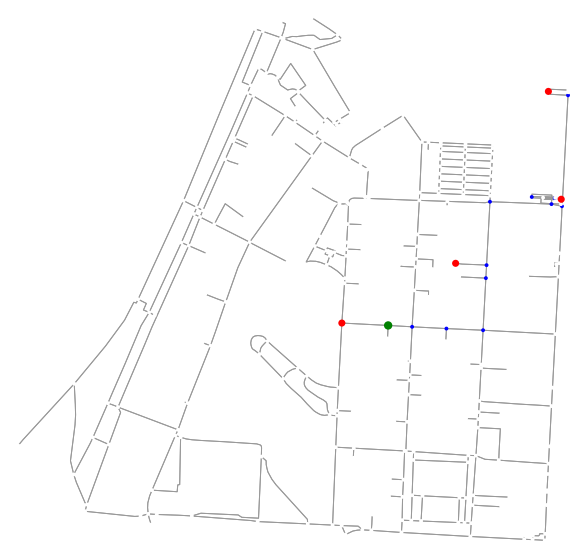

In [17]:
terminals = [t for t in G.nodes() if G.nodes[t]['prize'] > 0]
node_list_after_reduction = list(G.nodes())

ox.plot_graph(G_ox, figsize=(14, 10),
    bgcolor='#FFF',
    node_color=['g' if n == root else 'r' if n in terminals else 'b' if n in node_list_after_reduction else 'w' for n in node_list],
    node_size=[70 if n == root else 50 if n in terminals else 15 for n in node_list]);

# Use gurobi to run the optimisation problem

In [18]:
time_start = time.time()
solution, best_val_red = pu.gurobi(G, root, False, term_deg2, nodes_deg3, False, fixed_terminals)
time_end = time.time()
gurobi_with_reductions_time = time_end - time_start

print("\nGurobi took " + str(gurobi_with_reductions_time) + " Seconds to compute.")
print("Edges in solution (for debugging): ", solution, "\n")

Changed value of parameter threads to 3
   Prev: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 6 physical cores, 6 logical processors, using up to 3 threads
Optimize a model with 94 rows, 62 columns and 363 nonzeros
Model fingerprint: 0xf4617309
Variable types: 0 continuous, 62 integer (46 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e+00, 3e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 268.4900000
Presolve removed 14 rows and 5 columns
Presolve time: 0.00s
Presolved: 80 rows, 57 columns, 297 nonzeros
Variable types: 0 continuous, 57 integer (41 binary)

Root relaxation: objective 7.548810e+02, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     754.8810000  754.88100

## Plot the solution

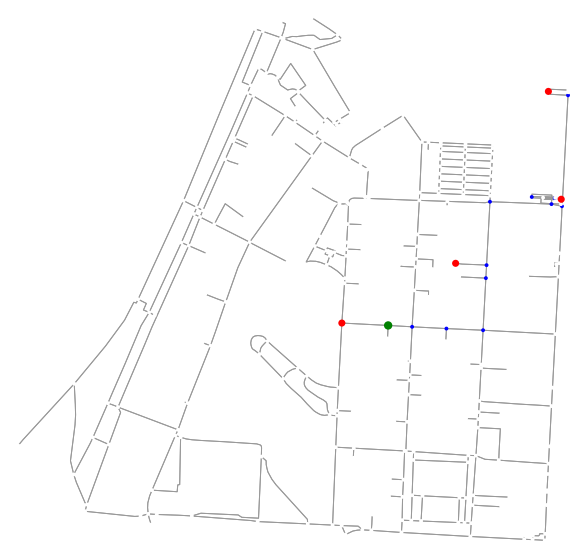

In [19]:
node_list1 = [u for (u, v) in solution]
node_list2 = [v for (u, v) in solution]
res_node_list = list(set(node_list1 + node_list2))
res_terminals = [t for t in res_node_list if t in terminals]


ox.plot_graph(G_ox, figsize=(14, 10),
    bgcolor='#FFF',
    node_color=['g' if n == root else 'r' if n in res_terminals else 'b' if n in res_node_list else 'w' for n in node_list],
    node_size=[70 if n == root else 50 if n in res_terminals else 15 for n in node_list]);

## Compare times used

In [20]:
print("Time without reductions: ", gurobi_without_reductions_time, ".")
print("Time with reductions: ", str((basic_reductions_time) + voronoi_time + dualAscent_time + gurobi_with_reductions_time), ".")
print("Obj. value without reductions: ", best_val)
print("Obj. value with reductions: ", best_val_red)

Time without reductions:  18.381881952285767 .
Time with reductions:  0.09799909591674805 .
Obj. value without reductions:  754.881
Obj. value with reductions:  754.8809999999997
